In [1]:
%load_ext autoreload
%autoreload 2
import util
import nest_asyncio
nest_asyncio.apply()
import multiprocessing
# set start method if not set 
if multiprocessing.get_start_method(allow_none=True) is None:
    multiprocessing.set_start_method("fork")
import pandas as pd
import stan
import numpy as np
from scipy.stats import pearsonr

from scipy.special import expit
import matplotlib.pyplot as plt
import arviz as az
import random
import json
import os

In [2]:
adj = np.load("data/processed/ct_nyc_adj_mtx.npy")
adj

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

## Matt Updates (8/25)
- Got conda environment that runs this notebook installed successfully 
- Now, to plug in real data 
- Anyway to suppress some of this output? 
- tried to add some upweighting to account for the fact that the 1000-image sample is not representative of overall image counts, not sure if this was the right intuition? The r_hat goes down to 1.0 for all of the fields, but there's this 'metropolis' error that pops up like 20 times. 
- i think something definitely needs to be done? these values aren't correct (which is what happens when i put 670/330 in, the raw counts of annotated neg/pos)

Working results that don't make sense 
- empirical_p_y 0.22638264951208253
- empirical_p_yhat 0.059639051600278256
- p_y_hat_1_given_y_1 0.21163348990040542
- p_y_hat_1_given_y_0 0.015385530450161835
- p_y_1_given_y_hat_1 0.8033352121400738
- p_y_1_given_y_hat_0 0.1897914834156601
- number of annotated classified negative which were positive: 132/670
- number of annotated classified positive which were positive: 276/330

In [3]:
# load actual reuslts 
ct_dataset = pd.read_csv("data/processed/flooding_ct_dataset.csv")
ct_dataset[['total_images','positive_images']] = ct_dataset[['n_total','n_classified_positive']].astype(int).fillna(0)
print(ct_dataset.isna().sum())
ct_dataset.columns

CTLabel                    0
BoroCode                   0
BoroName                   0
CT2020                     0
BoroCT2020                 0
CDEligibil                 0
NTAName                    0
NTA2020                    0
CDTA2020                   0
CDTANAME                   0
GEOID                      0
PUMA                       0
Shape_Leng                 0
Shape_Area                 0
geometry                   0
n_total                    0
n_classified_positive      0
n_tp                       0
n_fp                       0
n_tn                       0
n_fn                       0
total_not_annotated        0
positives_not_annotated    0
negatives_not_annotated    0
total_images               0
positive_images            0
dtype: int64


Index(['CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020', 'CDEligibil',
       'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID', 'PUMA',
       'Shape_Leng', 'Shape_Area', 'geometry', 'n_total',
       'n_classified_positive', 'n_tp', 'n_fp', 'n_tn', 'n_fn',
       'total_not_annotated', 'positives_not_annotated',
       'negatives_not_annotated', 'total_images', 'positive_images'],
      dtype='object')

In [4]:
ct_dataset

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,n_classified_positive,n_tp,n_fp,n_tn,n_fn,total_not_annotated,positives_not_annotated,negatives_not_annotated,total_images,positive_images
0,1.00,1,Manhattan,100,1000100,0,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2.01,1,Manhattan,201,1000201,0,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),...,0.0,0.0,0.0,0.0,0.0,320.0,0.0,320.0,320,0
2,6.00,1,Manhattan,600,1000600,0,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),...,2.0,1.0,0.0,1.0,0.0,843.0,1.0,843.0,845,2
3,14.01,1,Manhattan,1401,1001401,0,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),...,0.0,0.0,0.0,0.0,0.0,182.0,0.0,182.0,182,0
4,14.02,1,Manhattan,1402,1001402,0,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),...,0.0,0.0,0.0,1.0,0.0,770.0,0.0,771.0,771,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,176.00,5,Staten Island,17600,5017600,0,Annadale-Huguenot-Prince's Bay-Woodrow,SI0304,SI03,SI03 South Shore (CD 3 Approximation),...,0.0,0.0,0.0,0.0,0.0,76.0,0.0,76.0,76,0
2323,228.02,5,Staten Island,22802,5022802,0,Freshkills Park (North),SI0291,SI02,SI02 Mid-Island (CD 2 Approximation),...,1.0,0.0,0.0,0.0,0.0,204.0,1.0,203.0,204,1
2324,291.02,5,Staten Island,29102,5029102,0,New Springville-Willowbrook-Bulls Head-Travis,SI0204,SI02,SI02 Mid-Island (CD 2 Approximation),...,0.0,0.0,0.0,1.0,0.0,1263.0,0.0,1264.0,1264,0
2325,161.00,2,Bronx,16100,2016100,0,Crotona Park East,BX0303,BX03,BX03 Morrisania-Crotona Park East (CD 3 Approx...,...,0.0,0.0,0.0,0.0,0.0,264.0,0.0,264.0,264,0


In [5]:
ct_dataset['positive_rate'] = ct_dataset['positive_images']/ct_dataset['total_images']
ct_dataset['positive_rate'] = ct_dataset['positive_rate'].fillna(0)
ct_dataset['positive_rate'].describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

count    2327.000000
mean        0.001586
std         0.007360
min         0.000000
1%          0.000000
2.5%        0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
90%         0.003737
95%         0.007862
97.5%       0.013158
99%         0.025000
max         0.166667
Name: positive_rate, dtype: float64

# Emma notes (8/22):

In general, let's build complexity iteratively. Start by getting reasonable results without worrying about ICAR prior/smoothing. Then use standard ICAR prior (with weight 0.5). Then use full CAR (maybe). Data generation code is reviewed + model without proper CAR prior is reviewed. Another thing it might be nice to implement at some point is using the information about where the annotated images are (i.e., what Census tracts). Could incorporate this as a multinomial (potentially?) 

Model with simple L2 smoothing (or no smoothing at all - stan_code_with_weighted_ICAR_prior):

1. Consistently recovers parameters for realistic parameter settings (with no smoothing)
2. Reviewed Stan code and looks good. 
3. ALso implemented L2 regularization for adjacent Census tracts. This isn't actually the "proper" way to do it, but might be useful on real data. Haven't tested how this performs. 

Model wih full CAR prior (stan_code_proper_car_prior):

1. Haven't reviewed this or verified it recovers correct params (recently; I think I did a while ago). When you do review, don't need to re-review all the Bayesian conditioning math; it should be pretty similar to the old code. 


dict_keys(['N', 'W', 'W_n', 'N_edges', 'node1', 'node2', 'n_images_by_area', 'n_classified_positive_by_area', 'n_classified_positive_annotated_positive_by_area', 'n_classified_positive_annotated_negative_by_area', 'n_classified_negative_annotated_negative_by_area', 'n_classified_negative_annotated_positive_by_area', 'n_non_annotated_by_area', 'n_non_annotated_by_area_classified_positive', 'use_ICAR_prior', 'ICAR_prior_weight'])
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (302/10000)
Sampling:   4% (402/10000)
Sampling:   5% (501/10000)
Sampling:   6% (601/10000)
Sampling:   7% (701/10000)
Sampling:   8% (801/10000)
Sampling:   9% (901/10000)
Sampling:  10% (1001/10000)
Sampling:  11% (1101/10000)
Sampling:  12% (1201/10000)
Sampling:  13% (1301/10000)
Sampling:  14% (1401/10000)
Sampling:  15% (1501/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  20% (2000/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  23% (2300/10000)
Sampling:  24% (2400/10000)
Sampling:  25% (2500/10000)
Sampling:  26

                                            mean     sd  hdi_3%  hdi_97%  \
p_y_hat_1_given_y_1                        0.457  0.125   0.237    0.675   
p_y_hat_1_given_y_0                        0.000  0.000   0.000    0.000   
phi_offset                                -6.704  0.280  -7.168   -6.119   
p_y_1_given_y_hat_1                        0.754  0.017   0.720    0.786   
p_y_1_given_y_hat_0                        0.002  0.001   0.000    0.003   
...                                          ...    ...     ...      ...   
at_least_one_positive_image_by_area[2322]  0.123  0.120   0.002    0.346   
at_least_one_positive_image_by_area[2323]  0.371  0.245   0.017    0.830   
at_least_one_positive_image_by_area[2324]  0.597  0.248   0.196    1.000   
at_least_one_positive_image_by_area[2325]  0.297  0.213   0.017    0.712   
at_least_one_positive_image_by_area[2326]  0.286  0.217   0.007    0.702   

                                           mcse_mean  mcse_sd  ess_bulk  \
p_y_hat_1_gi

/share/ju/conda_virtualenvs/stan/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/tmp/ipykernel_2827952/3861942103.py:163: RuntimeWarning: invalid value encountered in divide
  empirical_p_yhat = data_to_use['observed_data']['n_classified_positive_by_area'] / data_to_use['observed_data']['n_images_by_area']


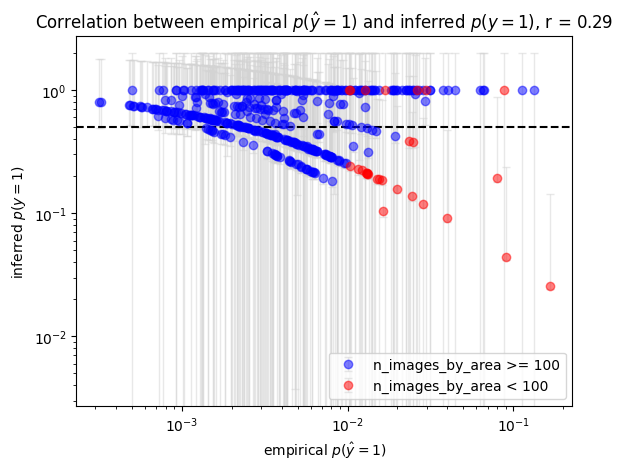

In [6]:

N_ANNOTATED_CLASSIFIED_NEGATIVE = 500 
N_ANNOTATED_CLASSIFIED_POSITIVE = 500 
N_ANNOTATED_CLASSIFIED_NEGATIVE_TRUE_POSITIVE = 3
N_ANNOTATED_CLASSIFIED_POSITIVE_TRUE_POSITIVE = 329

icar_prior_setting = 'none'
annotations_have_locations = True
use_simulated_data = False
assert icar_prior_setting in ['none', 'cheating', 'proper', 'just_model_p_y']
stan_code_with_weighted_ICAR_prior = open('stan_models/weighted_ICAR_prior.stan').read()
stan_code_proper_car_prior = open('stan_models/proper_car_prior.stan').read()
stan_model_uniform_p_y = open('stan_models/uniform_p_y_prior_just_for_debugging.stan').read()
stan_code_with_weighted_ICAR_prior_annotations_have_locations = open('stan_models/weighted_ICAR_prior_annotations_have_locations.stan').read()

OBSERVED_DATA_FLAG = 'simulated' if use_simulated_data else 'real'

# Total counts in the dataset
TOTAL_PRED_POSITIVE = 1465 
TOTAL_PRED_NEGATIVE = 924747



for i in range(1):
    NUM_WARMUP = 1000#3000
    NUM_SAMPLES = 1500
    if use_simulated_data:
        N = 1000
        data_to_use = util.generate_simulated_data(N=N, 
                                                images_per_location=1000, 
                                                total_annotated_classified_negative=500, 
                                                total_annotated_classified_positive=500, 
                                                icar_prior_setting=icar_prior_setting, 
                                                annotations_have_locations=annotations_have_locations)
    else:
        data_to_use = util.read_real_data(annotations_have_locations=annotations_have_locations)
    if icar_prior_setting == 'proper':
        raise Exception("Haven't verified that this model actually works! Need to review it / check on simulated data. No need to review the parts which are identical to the other model.")
        W = np.zeros((N, N))
        
        for i in range(len(simulated_data['observed_data']['node1'])):
            W[simulated_data['observed_data']['node1'][i] - 1, 
                                simulated_data['observed_data']['node2'][i] - 1] = 1
            W[simulated_data['observed_data']['node2'][i] - 1, 
                                simulated_data['observed_data']['node1'][i] - 1] = 1
        del simulated_data['observed_data']['node1']
        del simulated_data['observed_data']['node2']
        simulated_data['observed_data']['W'] = W
        simulated_data['observed_data']['W_n'] = int(W.sum() / 2)
        model = stan.build(stan_code_proper_car_prior, data=simulated_data['observed_data'])
    elif icar_prior_setting == 'cheating':
        data_to_use['observed_data']['use_ICAR_prior'] = 1
        data_to_use['observed_data']['ICAR_prior_weight'] = 0.5
        if annotations_have_locations:
            model = stan.build(stan_code_with_weighted_ICAR_prior_annotations_have_locations, data=data_to_use['observed_data'])
        else:
            model = stan.build(stan_code_with_weighted_ICAR_prior, data=data_to_use['observed_data'])
    elif icar_prior_setting == 'none':
        data_to_use['observed_data']['use_ICAR_prior'] = 0
        data_to_use['observed_data']['ICAR_prior_weight'] = 0
        print(data_to_use['observed_data'].keys())
        if annotations_have_locations:

            # write jsonified observed data to file for debugging
            # need to convert numpy arrays to lists
            observed_data_copy = data_to_use['observed_data'].copy()
            # observed_data_copy is a dict 
            for k in observed_data_copy.keys():
                if isinstance(observed_data_copy[k], np.ndarray):
                    observed_data_copy[k] = observed_data_copy[k].tolist()
                # serialized int64 
                if isinstance(observed_data_copy[k], np.int64):
                    observed_data_copy[k] = int(observed_data_copy[k])
                # serialize nd arrays with int 64 elements 
                if isinstance(observed_data_copy[k], list):
                    for i in range(len(observed_data_copy[k])):
                        if isinstance(observed_data_copy[k][i], np.int64):
                            observed_data_copy[k][i] = int(observed_data_copy[k][i])

            with open(f'observed_data_{OBSERVED_DATA_FLAG}_raw.json', 'w') as f:
                json.dump(observed_data_copy, f)

            # also, dump the sums of each array 
            with open(f'observed_data_{OBSERVED_DATA_FLAG}_sums.json', 'w') as f:
                sums = {}
                for k in observed_data_copy.keys():
                    sums[k] = float(np.sum(observed_data_copy[k]))
                json.dump(sums, f)

            # validate observed data 
            util.validate_observed_data(observed_data_copy, annotations_have_locations)


            model = stan.build(stan_code_with_weighted_ICAR_prior_annotations_have_locations, data=data_to_use['observed_data'])
        else:
            model = stan.build(stan_code_with_weighted_ICAR_prior, data=data_to_use['observed_data'])
    elif icar_prior_setting == 'just_model_p_y':
        del data_to_use['observed_data']['node1']
        del data_to_use['observed_data']['node2']
        del data_to_use['observed_data']['N_edges']
        model = stan.build(stan_model_uniform_p_y, data=data_to_use['observed_data'])
    else:
        raise ValueError("Invalid icar_prior_options", icar_prior_setting)
    fit = model.sample(num_chains=4, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)
    df = fit.to_frame()
    if icar_prior_setting == 'just_model_p_y':
        print(az.summary(fit, var_names=['p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
                                        'p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
                                        'empirical_p_yhat', 'p_y']))
    else:
        print(az.summary(fit, var_names=['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 'phi_offset', 
                                    'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
                                    'empirical_p_yhat', 'p_y', 'at_least_one_positive_image_by_area']))

        os.makedirs(f"runs/jupyter_notebook_test", exist_ok=True)
        with open(f"runs/jupyter_notebook_test/summary.txt", "w") as f:
                f.write(
                    az.summary(
                        fit,
                        var_names=[
                            "p_y_hat_1_given_y_1",
                            "p_y_hat_1_given_y_0",
                            "phi_offset",
                            "p_y_1_given_y_hat_1",
                            "p_y_1_given_y_hat_0",
                            "empirical_p_yhat",
                        ]
                    ).to_string()
                )
        
    if use_simulated_data:
        estimate = [df[f'at_least_one_positive_image_by_area.{i}'].mean() for i in range(1, N + 1)]
        plt.scatter(data_to_use['parameters']['p_Y'], estimate)
        plt.title("True vs. inferred estimate, r = %.2f" %
                pearsonr(data_to_use['parameters']['p_Y'], estimate)[0])
        max_val = max(max(data_to_use['parameters']['p_Y']), max(estimate))
        plt.xlabel("True p")
        plt.ylabel("Inferred p")
        plt.plot([0, max_val], [0, max_val], 'r--')
        plt.xlim([0, max_val])
        plt.ylim([0, max_val])
        plt.figure(figsize=[12, 3])


        if icar_prior_setting == 'proper':
            param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset', 'alpha', 'tau']
        elif icar_prior_setting == 'just_model_p_y':
            param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset']
        else:
            param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0']
        for k in param_names:
            plt.subplot(1, len(param_names), param_names.index(k) + 1)
            # histogram of posterior samples
            plt.hist(df[k], bins=50, density=True)
            plt.title(k)
            plt.axvline(data_to_use['parameters'][k], color='red')
        plt.show()
    else:
        empirical_p_yhat = data_to_use['observed_data']['n_classified_positive_by_area'] / data_to_use['observed_data']['n_images_by_area']
        print("Warning: %i of %i empirical p_yhat values are 0; these are being ignored" % (sum(np.isnan(empirical_p_yhat)), len(empirical_p_yhat)))
        estimate = np.array([df[f'at_least_one_positive_image_by_area.{i}'].mean() for i in range(1, len(empirical_p_yhat) + 1)])
        estimate_CIs = [df[f'at_least_one_positive_image_by_area.{i}'].quantile([0.025, 0.975]) for i in range(1, len(empirical_p_yhat) + 1)]
        n_images_by_area = data_to_use['observed_data']['n_images_by_area']
        # make errorbar plot
        image_cutoff = 100

        plt.errorbar(empirical_p_yhat[n_images_by_area >= image_cutoff], estimate[n_images_by_area >= image_cutoff], 
                    yerr=np.array(estimate_CIs)[n_images_by_area >= image_cutoff].T, fmt='o', 
                    color='blue', 
                    ecolor='lightgray', elinewidth=1, capsize=3, alpha=0.5, 
                    label="n_images_by_area >= %i" % image_cutoff)

        plt.errorbar(empirical_p_yhat[n_images_by_area < image_cutoff], estimate[n_images_by_area < image_cutoff], 
                    yerr=np.array(estimate_CIs)[n_images_by_area < image_cutoff].T, fmt='o', 
                    color='red', 
                    ecolor='lightgray', elinewidth=1, capsize=3, alpha=0.5, 
                    label="n_images_by_area < %i" % image_cutoff)
        plt.legend()

        # plot prior on p_y as vertical line. 
        prior_on_p_y = expit(df['phi_offset']).mean()
        plt.axhline(expit(prior_on_p_y), color='black', linestyle='--')
        is_nan = np.isnan(empirical_p_yhat)
        plt.title("Correlation between empirical $p(\\hat y = 1)$ and inferred $p(y = 1)$, r = %.2f" % pearsonr(empirical_p_yhat[~is_nan], estimate[~is_nan])[0])
        plt.xlabel("empirical $p(\\hat y = 1)$")
        plt.ylabel("inferred $p(y = 1)$")
        # logarithmic axes
        plt.xscale('log')
        plt.yscale('log')

In [7]:
pd.Series(estimate).describe([0.01, 0.025, 0.05, 0.125, 0.25, 0.5, 0.75, 0.875, 0.95, 0.975, 0.99])

count    2327.000000
mean        0.349816
std         0.246532
min         0.000000
1%          0.034314
2.5%        0.057842
5%          0.083020
12.5%       0.132484
25%         0.183442
50%         0.276319
75%         0.439119
87.5%       0.625666
95%         1.000000
97.5%       1.000000
99%         1.000000
max         1.000000
dtype: float64

In [8]:
# write estimate to csv 
estimate_df = pd.Series(estimate).to_frame('estimate')
estimate_df.to_csv('data/processed/estimate.csv')

Text(0.5, 1.0, 'Probability of at least one image being positive in census tract')

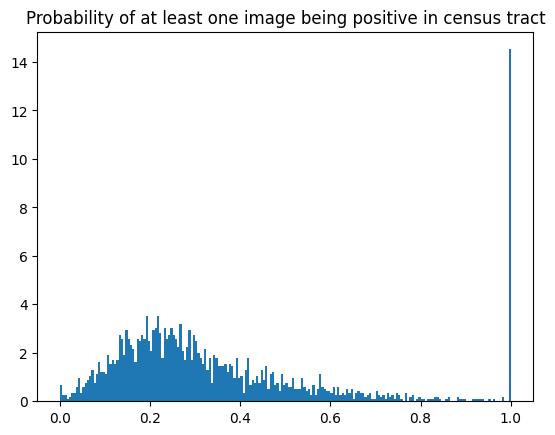

In [9]:
# histogram of inferred p_y 
fig, ax = plt.subplots()
ax.hist(estimate, bins=200, density=True)
ax.set_title("Probability of at least one image being positive in census tract")
